In [1]:
!pip install albumentations 

In [2]:
import numpy as np
import cv2
import glob
from torch.utils.data import Dataset
from PIL import Image
import os


In [3]:
# from https://github.com/amdegroot/ssd.pytorch
#水増し

import torch
#from torchvision import transforms
import cv2
import numpy as np
import types
from numpy import random


def intersect(box_a, box_b):
    max_xy = np.minimum(box_a[:, 2:], box_b[2:])
    min_xy = np.maximum(box_a[:, :2], box_b[:2])
    inter = np.clip((max_xy - min_xy), a_min=0, a_max=np.inf)
    return inter[:, 0] * inter[:, 1]


def jaccard_numpy(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: Multiple bounding boxes, Shape: [num_boxes,4]
        box_b: Single bounding box, Shape: [4]
    Return:
        jaccard overlap: Shape: [box_a.shape[0], box_a.shape[1]]
    """
    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1]))  # [A,B]
    area_b = ((box_b[2]-box_b[0]) *
              (box_b[3]-box_b[1]))  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]


class Compose(object):
    """Composes several augmentations together.
    Args:
        transforms (List[Transform]): list of transforms to compose.
    Example:
        >>> augmentations.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, boxes=None, labels=None):
        for t in self.transforms:
            img, boxes, labels = t(img, boxes, labels)
        return img, boxes, labels


class Lambda(object):
    """Applies a lambda as a transform."""

    def __init__(self, lambd):
        assert isinstance(lambd, types.LambdaType)
        self.lambd = lambd

    def __call__(self, img, boxes=None, labels=None):
        return self.lambd(img, boxes, labels)


class ConvertFromInts(object):
    def __call__(self, image, boxes=None, labels=None):
        return image.astype(np.float32), boxes, labels


class SubtractMeans(object):
    def __init__(self, mean):
        self.mean = np.array(mean, dtype=np.float32)

    def __call__(self, image, boxes=None, labels=None):
        image = image.astype(np.float32)
        image -= self.mean
        return image.astype(np.float32), boxes, labels


class ToAbsoluteCoords(object):
    def __call__(self, image, boxes=None, labels=None):
        height, width, channels = image.shape
        boxes[:, 0] *= width
        boxes[:, 2] *= width
        boxes[:, 1] *= height
        boxes[:, 3] *= height

        return image, boxes, labels


class ToPercentCoords(object):
    def __call__(self, image, boxes=None, labels=None):
        height, width, channels = image.shape
        boxes[:, 0] /= width
        boxes[:, 2] /= width
        boxes[:, 1] /= height
        boxes[:, 3] /= height

        return image, boxes, labels


class Resize(object):
    def __init__(self, size=300):
        self.size = size

    def __call__(self, image, boxes=None, labels=None):
        image = cv2.resize(image, (self.size,
                                 self.size))
        return image, boxes, labels


class RandomSaturation(object):
    def __init__(self, lower=0.5, upper=1.5):
        self.lower = lower
        self.upper = upper
        assert self.upper >= self.lower, "contrast upper must be >= lower."
        assert self.lower >= 0, "contrast lower must be non-negative."

    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            image[:, :, 1] *= random.uniform(self.lower, self.upper)

        return image, boxes, labels


class RandomHue(object):
    def __init__(self, delta=18.0):
        assert delta >= 0.0 and delta <= 360.0
        self.delta = delta

    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            image[:, :, 0] += random.uniform(-self.delta, self.delta)
            image[:, :, 0][image[:, :, 0] > 360.0] -= 360.0
            image[:, :, 0][image[:, :, 0] < 0.0] += 360.0
        return image, boxes, labels


class RandomLightingNoise(object):
    def __init__(self):
        self.perms = ((0, 1, 2), (0, 2, 1),
                      (1, 0, 2), (1, 2, 0),
                      (2, 0, 1), (2, 1, 0))

    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            swap = self.perms[random.randint(len(self.perms))]
            shuffle = SwapChannels(swap)  # shuffle channels
            image = shuffle(image)
        return image, boxes, labels


class ConvertColor(object):
    def __init__(self, current, transform):
        self.transform = transform
        self.current = current

    def __call__(self, image, boxes=None, labels=None):
        if self.current == 'BGR' and self.transform == 'HSV':
            image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif self.current == 'RGB' and self.transform == 'HSV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif self.current == 'BGR' and self.transform == 'RGB':
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif self.current == 'HSV' and self.transform == 'BGR':
            image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
        elif self.current == 'HSV' and self.transform == "RGB":
            image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
        else:
            raise NotImplementedError
        return image, boxes, labels


class RandomContrast(object):
    def __init__(self, lower=0.5, upper=1.5):
        self.lower = lower
        self.upper = upper
        assert self.upper >= self.lower, "contrast upper must be >= lower."
        assert self.lower >= 0, "contrast lower must be non-negative."

    # expects float image
    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            alpha = random.uniform(self.lower, self.upper)
            image *= alpha
        return image, boxes, labels

import albumentations as albu
class ISONoise(object):
    def __init__(self, color_shift = (0.1, 0.3), intensity = (0.1, 0.3), p = 0.3):
        self.color_shift = color_shift
        self.intensity = intensity
        self.p = p
    def __call__(self, image, boxes=None, labels=None):
        image = albu.augmentations.transforms.ISONoise(color_shift = self.color_shift, intensity = self.intensity, p = self.p)(image=image)['image']
        return image, boxes, labels
        
class RandomBrightness(object):
    def __init__(self, delta=32):
        assert delta >= 0.0
        assert delta <= 255.0
        self.delta = delta

    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            delta = random.uniform(-self.delta, self.delta)
            image += delta
        return image, boxes, labels

class ToCV2Image(object):
    def __call__(self, tensor, boxes=None, labels=None):
        return tensor.cpu().numpy().astype(np.float32).transpose((1, 2, 0)), boxes, labels


class ToTensor(object):
    def __call__(self, cvimage, boxes=None, labels=None):
        return torch.from_numpy(cvimage.astype(np.float32)).permute(2, 0, 1), boxes, labels


class RandomSampleCrop(object):
    """Crop
    Arguments:
        img (Image): the image being input during training
        boxes (Tensor): the original bounding boxes in pt form
        labels (Tensor): the class labels for each bbox
        mode (float tuple): the min and max jaccard overlaps
    Return:
        (img, boxes, classes)
            img (Image): the cropped image
            boxes (Tensor): the adjusted bounding boxes in pt form
            labels (Tensor): the class labels for each bbox
    """
    def __init__(self):
        self.sample_options = (
            # using entire original input image
            None,
            # sample a patch s.t. MIN jaccard w/ obj in .1,.3,.4,.7,.9
            (0.1, None),
            (0.3, None),
            (0.7, None),
            (0.9, None),
            # randomly sample a patch
            (None, None),
        )

    def __call__(self, image, boxes=None, labels=None):
        height, width, _ = image.shape
        while True:
            # randomly choose a mode
            mode = random.choice(self.sample_options)
            if mode is None:
                return image, boxes, labels

            min_iou, max_iou = mode
            if min_iou is None:
                min_iou = float('-inf')
            if max_iou is None:
                max_iou = float('inf')

            # max trails (50)
            for _ in range(50):
                current_image = image

                w = random.uniform(0.3 * width, width)
                h = random.uniform(0.3 * height, height)

                # aspect ratio constraint b/t .5 & 2
                if h / w < 0.5 or h / w > 2:
                    continue

                left = random.uniform(width - w)
                top = random.uniform(height - h)

                # convert to integer rect x1,y1,x2,y2
                rect = np.array([int(left), int(top), int(left+w), int(top+h)])

                # calculate IoU (jaccard overlap) b/t the cropped and gt boxes
                overlap = jaccard_numpy(boxes, rect)

                # is min and max overlap constraint satisfied? if not try again
                if overlap.min() < min_iou and max_iou < overlap.max():
                    continue

                # cut the crop from the image
                current_image = current_image[rect[1]:rect[3], rect[0]:rect[2],
                                              :]

                # keep overlap with gt box IF center in sampled patch
                centers = (boxes[:, :2] + boxes[:, 2:]) / 2.0

                # mask in all gt boxes that above and to the left of centers
                m1 = (rect[0] < centers[:, 0]) * (rect[1] < centers[:, 1])

                # mask in all gt boxes that under and to the right of centers
                m2 = (rect[2] > centers[:, 0]) * (rect[3] > centers[:, 1])

                # mask in that both m1 and m2 are true
                mask = m1 * m2

                # have any valid boxes? try again if not
                if not mask.any():
                    continue

                # take only matching gt boxes
                current_boxes = boxes[mask, :].copy()

                # take only matching gt labels
                current_labels = labels[mask]

                # should we use the box left and top corner or the crop's
                current_boxes[:, :2] = np.maximum(current_boxes[:, :2],
                                                  rect[:2])
                # adjust to crop (by substracting crop's left,top)
                current_boxes[:, :2] -= rect[:2]

                current_boxes[:, 2:] = np.minimum(current_boxes[:, 2:],
                                                  rect[2:])
                # adjust to crop (by substracting crop's left,top)
                current_boxes[:, 2:] -= rect[:2]

                return current_image, current_boxes, current_labels


class Expand(object):
    def __init__(self, mean):
        self.mean = mean

    def __call__(self, image, boxes, labels):
        if random.randint(2):
            return image, boxes, labels

        height, width, depth = image.shape
        ratio = random.uniform(1, 2)
        left = random.uniform(0, width*ratio - width)
        top = random.uniform(0, height*ratio - height)

        expand_image = np.zeros(
            (int(height*ratio), int(width*ratio), depth),
            dtype=image.dtype)
        expand_image[:, :, :] = self.mean
        expand_image[int(top):int(top + height),
                     int(left):int(left + width)] = image
        image = expand_image

        boxes = boxes.copy()
        boxes[:, :2] += (int(left), int(top))
        boxes[:, 2:] += (int(left), int(top))

        return image, boxes, labels


class RandomMirror(object):
    def __call__(self, image, boxes, classes):
        _, width, _ = image.shape
        if random.randint(2):
            image = image[:, ::-1]
            boxes = boxes.copy()
            boxes[:, 0::2] = width - boxes[:, 2::-2]
        return image, boxes, classes


"""
class PhotometricDistort(object):
    def __init__(self):
        self.pd = [
            RandomContrast(),  # RGB
            ConvertColor(current="RGB", transform='HSV'),  # HSV
            RandomSaturation(),  # HSV
            RandomHue(),  # HSV
            ConvertColor(current='HSV', transform='RGB'),  # RGB
            RandomContrast()  # RGB
        ]
        #self.rand_brightness = RandomBrightness()
        self.rand_light_noise = RandomLightingNoise()

    def __call__(self, image, boxes, labels):
        im = image.copy()
        #im, boxes, labels = self.rand_brightness(im, boxes, labels)
        if random.randint(2):
            distort = Compose(self.pd[:-1])
        else:
            distort = Compose(self.pd[1:])
        im, boxes, labels = distort(im, boxes, labels)
        return self.rand_light_noise(im, boxes, labels)
"""
class DisplayObject(object):
    def __call__(self, image, boxes, labels):
        outimg = image.astype(np.uint8).copy()
        for i, box in enumerate(boxes):
            print(box)
            h, w, _ = image.shape
            box[0] *= w
            box[1] *= h
            box[2] *= w
            box[3] *= h
            cv2.rectangle(outimg, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 0),  thickness=8)
            cv2.putText(outimg, str(labels[i]),
                        (int(box[0]) + 20, int(box[1]) + 40),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1,  # font scale
                        (255, 0, 255),
                        2)  # line type
        display(cv2pil(outimg))
        return image, boxes, labels        

In [4]:
from PIL import Image
import cv2

def cv2pil(image):
    ''' OpenCV型 -> PIL型 '''
    new_image = image.copy()
    if new_image.ndim == 2:  # モノクロ
        pass
    elif new_image.shape[2] == 3:  # カラー
        new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
    elif new_image.shape[2] == 4:  # 透過
        new_image = cv2.cvtColor(new_image, cv2.COLOR_BGRA2RGBA)
    new_image = Image.fromarray(new_image)
    return new_image

In [5]:
class TrainAugmentation:
    def __init__(self, size, mean=0, std=1.0):
        """
        Args:
            size: the size the of final image.
            mean: mean pixel value per channel.
        """
        self.mean = mean
        self.size = size
        self.augment = Compose([
            #ISONoise(),
            ConvertFromInts(),
            #PhotometricDistort(),
            Expand(self.mean),
            RandomSampleCrop(),
            RandomMirror(),
            ToPercentCoords(),
            Resize(self.size),
            DisplayObject(),
            SubtractMeans(self.mean),
            lambda img, boxes=None, labels=None: (img / std, boxes, labels),
            ToTensor(),
        ])

    def __call__(self, img, boxes, labels):
        """

        Args:
            img: the output of cv.imread in RGB layout.
            boxes: boundding boxes in the form of (x1, y1, x2, y2).
            labels: labels of boxes.
        """
        return self.augment(img, boxes, labels)


In [6]:
import numpy as np
import cv2
import glob
from torch.utils.data import Dataset
from PIL import Image
import os
import albumentations as albu


import numpy as np
import cv2
import glob
from torch.utils.data import Dataset
from PIL import Image
import os
import albumentations as albu
import torch


class pseudoDatasetCan(Dataset):
    def __init__(self, config, transform, backgroundPaths, canPaths, length, target_transform=None):
        self.config = config
        self.transform = transform
        self.backgroundPaths = backgroundPaths
        self.canPaths = canPaths
        self.length = length
        self.target_transform = target_transform

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        #疑似画像を生成する
        canPaths = self.canPaths
        backgroundPaths = self.backgroundPaths
        boxes = []
        labels = []
        img = cv2.imread(np.random.choice(backgroundPaths))
        canImg = cv2.imread(np.random.choice(canPaths))
        hr = 300/img.shape[0]
        wr = 300/img.shape[1]
        img = cv2.resize(img, (300, 300))
        print(hr, wr, canImg.shape[0] * hr, canImg.shape[1] * wr)
        canImg = cv2.resize(canImg, (int(canImg.shape[1] * wr), int(canImg.shape[0] * hr)))
        canImg = self._crop_image(canImg)
        canImg = self._crop_width(canImg)
        img = self._color_change(img)
        canImg = self._color_change(canImg)
        img, xmin, xmax, ymin, ymax, _  = self._randomPasteImg(img, canImg, colorRotation = True, can = True)
        labels.append(1)
        boxes.append([xmin, ymin, xmax, ymax])
        boxes = np.array(boxes)
        labels = np.array(labels)
        #self._displayImg(img, boxes, labels)
        img, boxes, labels = self._getitem(img, boxes, labels)
        return img, boxes, labels

    def _getitem(self, img, boxes, labels):
        img = cv2.resize(img, (300, 300))
        boxes[:, 0] *= img.shape[1]
        boxes[:, 1] *= img.shape[0]
        boxes[:, 2] *= img.shape[1]
        boxes[:, 3] *= img.shape[0]
        img, boxes, labels = self.transform(img, boxes, labels)
        if self.target_transform:
            boxes, labels = self.target_transform(boxes, labels)
        else:
            boxes = torch.from_numpy(boxes)
            labels = torch.from_numpy(labels)
        boxes = boxes.to(torch.float32)
        labels = labels.to(torch.int64)
        return img, boxes, labels

    def _randomPasteImg(self, backgroundImg, targetImg, colorRotation = False, cone = False, can = False):
        #いい感じにペースト処理をする
        transparence = (255,255,255)
        if can == True:
            r = 0.6
        #ターゲット画像の白以外の部分色変える処理を入れる 
        targetImg = cv2.resize(targetImg, (int(r * targetImg.shape[1]), int(r *  targetImg.shape[0])))
        if colorRotation:
            changeimg = albu.RGBShift(p = 1.0)(image=targetImg)['image']
            changeimg = albu.ChannelShuffle(p = 0.3)(image=changeimg)['image']
            targetImg = np.where(targetImg==transparence, targetImg[:, :], changeimg[:, :])
        if(backgroundImg.shape[1] < targetImg.shape[1]):
            targetImg = targetImg[:, :backgroundImg.shape[1] - 1]
        if(backgroundImg.shape[0] < targetImg.shape[0]):
            targetImg = targetImg[:backgroundImg.shape[0] - 1, :]
        sx = np.random.randint(0, backgroundImg.shape[1] - targetImg.shape[1])
        sy = np.random.randint(0, backgroundImg.shape[0] - targetImg.shape[0])
        miximg = np.where(targetImg==transparence, backgroundImg[sy:sy+targetImg.shape[0], sx:sx+targetImg.shape[1]], targetImg)
        backgroundImg[sy:sy+targetImg.shape[0], sx:sx+targetImg.shape[1]] = miximg
        xmin = sx / backgroundImg.shape[1]
        xmax = (sx+targetImg.shape[1]) / backgroundImg.shape[1]
        ymin = sy / backgroundImg.shape[0]
        ymax = (sy+targetImg.shape[0]) / backgroundImg.shape[0]

        #backgroundImg = cv2.GaussianBlur(backgroundImg,(3,3),0)
        return backgroundImg, xmin, xmax, ymin, ymax, r
    
    def _displayImg(self, img, boxes, labels):
        img = cv2.resize(img, (300, 300))
        boxes[:, 0] *= img.shape[1]
        boxes[:, 1] *= img.shape[0]
        boxes[:, 2] *= img.shape[1]
        boxes[:, 3] *= img.shape[0]
        for i, box in enumerate(boxes):
            cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 0),  thickness=8)
            cv2.putText(img, str(labels[i]),
                        (int(box[0]) + 20, int(box[1]) + 40),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1,  # font scale
                        (255, 0, 255),
                        2)  # line type
        display(Image.fromarray(img))
    
    def _crop_image(self, canImg):
        h,w,_ = canImg.shape
        if w > h:
            #上見切れるとは思えない
            r = r = np.random.rand() * 0.4
            canImg = canImg[:int(h-h*r), :]
        else:     
            if np.random.rand() < 0.45:
                r = np.random.rand() * 0.4
                canImg = canImg[:int(h-h*r), :]
            elif np.random.rand() < 0.9:
                r = np.random.rand() * 0.4
                canImg = canImg[int(h*r):h, :]
            else:
                r = np.random.rand() * 0.2
                canImg = canImg[int(h*r):int(h-h*r), :]
        return canImg
    
    def _crop_width(self, img):
        h,w,_ = img.shape
        if np.random.rand() < 0.5:
            r = np.random.rand() * 0.3
            img = img[:, :int(w-w*r)]
        else:
            r = np.random.rand() * 0.3
            img = img[:, int(w*r):]
        return img
    
    def _color_change(self, img):
        transparence = (255,255,255)
        if np.random.rand() < 0.2:
            generateImg = albu.augmentations.transforms.RGBShift(r_shift_limit = (-30, 30), g_shift_limit = (-10, 10),b_shift_limit = (-30, 30),  p = 1.0)(image=img)['image']
            img = np.where(img==transparence, img, generateImg)
        if np.random.rand() < 0.2:
            generateImg = albu.augmentations.transforms.RandomFog(p = 1.0)(image=img)['image']
            img = np.where(img==transparence, img, generateImg)
        return img

In [7]:
from vision.ssd.config import mobilenetv1_ssd_config
config = mobilenetv1_ssd_config
from vision.ssd.ssd import MatchPrior
train_transform = TrainAugmentation(config.image_size, config.image_mean, config.image_std)
"""
train_transform = TrainAugmentation(config.image_size, config.image_mean, config.image_std)
target_transform = MatchPrior(config.priors, config.center_variance, config.size_variance, 0.5)
test_transform = TrainAugmentation(config.image_size, config.image_mean, config.image_std)
"""
backgroundPaths = glob.glob(os.path.join(".", "pseudo_data", "background", "*.JPG"))
conePaths = glob.glob(os.path.join(".", "pseudo_data", "cone", "*.png"))
canPaths = glob.glob(os.path.join(".", "pseudo_can", "*.png"))
#TODO 画像レングスセット
dataset_length = 10

pDataset = pseudoDatasetCan(config, train_transform, backgroundPaths, canPaths, dataset_length)

0.075 0.05 188.1 45.650000000000006
[0.         0.72864322 0.0877193  1.        ]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:255: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


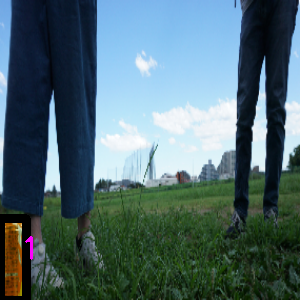

tensor([1])
0.075 0.05 96.375 90.45
[0.32105263 0.37623762 0.58947368 0.57425743]


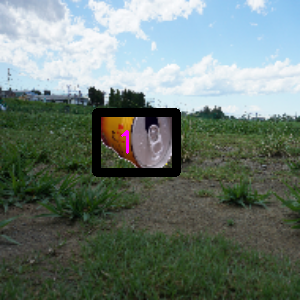

tensor([1])
0.075 0.05 150.225 49.300000000000004
[0.51412429 0.26977401 0.55508475 0.36016949]


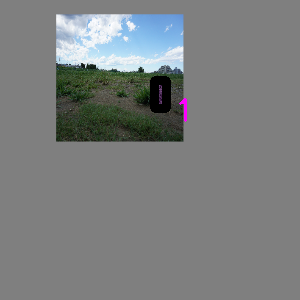

tensor([1])
0.075 0.05 163.65 53.0
[0.71333333 0.32978723 0.79666667 0.60638298]


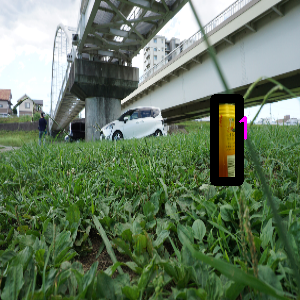

tensor([1])
0.075 0.05 255.975 98.65
[0.32571429 0.07272727 0.60571429 0.48727273]


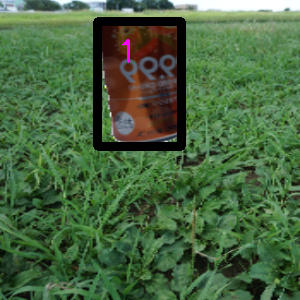

tensor([1])


In [9]:
for i in range(5):
    img, boxes, labels = pDataset[i]
    print(labels)